## Python Modules 

In [34]:
import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd
import xarray
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

## Geojson files import

In [35]:
#France geojson files
URL_French_regions='https://france-geojson.gregoiredavid.fr/repo/regions.geojson'
French_regions = gpd.read_file(URL_French_regions) 

URL_French_departments='https://france-geojson.gregoiredavid.fr/repo/departements.geojson'
French_departments = gpd.read_file(URL_French_departments)

path_wine_regions ='Geojson_files/bassinsviticolesfranceaop.geojson'
French_wine_regions=gpd.read_file(path_wine_regions)

In [36]:
#Picking all the regions related to the regions of agreste productivity data
French_wine_region_choice=[3,4,6,8,10]
# ALSACE ET EST,BOURGOGNE BEAUJOLAIS SAVOIE JURA,CHAMPAGNE,LANGUEDOC-ROUSSILLON,Sud_Ouest,Val de Loire

French_departments_choice=[54,71]
# Gironde(pour bordeaux), ,Charentes

#geojson manquants : Sud-est,Alsace,Champagne
#Données manquantes : Corse

# for i in range(len(French_departments)):
#     print(French_departments['nom'][i],i)

## Data exploration

In [37]:
file_name='era5-land'

#Extraction des caractéristiques
f= netCDF4.Dataset('era1/era5-land-2019-01.nc')
f.variables.keys()
np.asarray(f.variables['time'])
f.variables['sp']

<class 'netCDF4._netCDF4.Variable'>
int16 sp(time, latitude, longitude)
    scale_factor: 0.5523896357560313
    add_offset: 86484.09880518212
    _FillValue: -32767
    missing_value: -32767
    units: Pa
    long_name: Surface pressure
    standard_name: surface_air_pressure
unlimited dimensions: 
current shape = (744, 101, 141)
filling on

In [38]:
np.asarray(f['t2m']).shape

# Shape of data is : hourly measurement/latitude/longitude

(744, 101, 141)

In [39]:
French_wine_regions

,Bassin,geometry
0,ARMAGNAC,"MULTIPOLYGON (((0.49443 43.48731, 0.49028 43.4..."
1,COGNAC,"MULTIPOLYGON (((-0.11104 45.11531, -0.11327 45..."
2,VIN DOUX NATURELS,"MULTIPOLYGON (((3.15734 42.46017, 3.16230 42.4..."
3,ALSACE ET EST,"MULTIPOLYGON (((7.13889 47.80798, 7.14134 47.8..."
4,BOURGOGNE BEAUJOLAIS SAVOIE JURA,"MULTIPOLYGON (((4.67475 45.67896, 4.67021 45.6..."
5,CHAMPAGNE,"MULTIPOLYGON (((3.66164 48.29363, 3.65707 48.2..."
6,LANGUEDOC-ROUSSILLON,"MULTIPOLYGON (((2.67403 42.40481, 2.67303 42.4..."
7,PROVENCE-CORSE,"MULTIPOLYGON (((9.28728 41.48386, 9.28432 41.4..."
8,SUD-OUEST,"MULTIPOLYGON (((0.47417 44.11902, 0.47272 44.1..."
9,TOULOUSE-PYRENEES,"MULTIPOLYGON (((-1.16279 43.11780, -1.16155 43..."


In [40]:
French_wine_regions['geometry'][1]
print(French_wine_regions['Bassin'])


0                             ARMAGNAC
1                               COGNAC
2                    VIN DOUX NATURELS
3                        ALSACE ET EST
4     BOURGOGNE BEAUJOLAIS SAVOIE JURA
5                            CHAMPAGNE
6                 LANGUEDOC-ROUSSILLON
7                       PROVENCE-CORSE
8                            SUD-OUEST
9                    TOULOUSE-PYRENEES
10                        VAL DE LOIRE
11                     VALLEE DU RHÔNE
Name: Bassin, dtype: object


## Data selection and generation

In [41]:
def coord_lister(geom):
    
    if geom.geom_type=='MultiPolygon':
        coords = [list(x.exterior.coords) for x in geom.geoms]
    else:
        coords = list(geom.exterior.coords)        
    return (coords)


In [42]:

def data_period_pick(path,year_start,year_finish,month_start,month_finish):
    
    delta_year=year_finish-year_start
    delta_month=month_finish-month_start
    data_files=[]
    year_size_data=[]
    
    for i in range(year_start,year_finish+1):
        month_size_data=[]
        for j in range(month_start,month_finish+1):
            year_actual=str(i)
            month_actual=str(j)
            if j <= 9 :
                data_files.append(path+'-'+year_actual+'-'+'0'+month_actual+'.nc')
            else:
                 data_files.append(path+'-'+year_actual+'-'+month_actual+'.nc')
                
            data=netCDF4.Dataset(data_files[-1])
            month_size_data.append(len(data.variables['t2m']))
            
        year_size_data.append(np.sum(month_size_data))
    return data_files,delta_year,delta_month,year_size_data


In [43]:
def data_year_sep(data,year_size_data):
    
    data_matrix_year=[]
    _iter=0
    
    for i in range(len(year_size_data)):
                                   
        size_year_actual = year_size_data[i]
        _iter_end=_iter+size_year_actual
        data_matrix_year.append(data[int(_iter):int(_iter_end)])                          
        _iter+=year_size_data[i]
            
    return data_matrix_year
                                         

In [44]:
def coordinates_region(geojson_file,region_choice):
    
        if geojson_file[region_choice].geom_type=='MultiPolygon':

            coordinates = coord_lister(geojson_file[region_choice])
            nb_polygons=len(coordinates)
            
            data_coords=[]
            for j in range(nb_polygons):

                coords = coordinates[j]
                coords=np.round(coords,1)
                min_lat=min(coords[:,1])
                max_lat=max(coords[:,1])
                lat_list_iter=np.arange(min_lat,max_lat,0.1)
            
                for latitude in lat_list_iter:

                    idx_long=np.where(coords[:,1]==np.round(latitude,1))[0]
                    long_values_at_iter_lat=coords[:,0][idx_long]
                    long_list_iter=np.arange(min(long_values_at_iter_lat),max(long_values_at_iter_lat),0.1)
                    
                    for longitude in long_list_iter:
                        
                        data_coords.append([latitude,longitude])
                # Long_list_department.append(long_list)
                
            # return np.hstack(Lat_list_department),Long_list_department
            return data_coords

        else:    
            
            data_coords=[]
            coordinates = coord_lister(geojson_file[region_choice])
            coordinates=np.round(coordinates,1)
            min_lat=min(coordinates[:,1])
            max_lat=max(coordinates[:,1])
            lat_list=np.arange(min_lat,max_lat,0.1)
            
            for latitude in lat_list:

                idx_long=np.where(coordinates[:,1]==np.round(latitude,1))[0]
                long_values_at_iter_lat=coordinates[:,0][idx_long]
                long_list_iter=np.arange(min(long_values_at_iter_lat),max(long_values_at_iter_lat),0.1)
                 
                for longitude in long_list_iter:
                        
                        data_coords.append([latitude,longitude])
                        
            return data_coords
        
def data_ready_model(data_coords,path_picked_files,data_feature):

        data_variable=[]

        for file in range(len(path_picked_files)):

            main_data= netCDF4.Dataset(path_picked_files[file])
            data=np.asarray(main_data.variables[data_feature]).T
            # print(data.shape)
            lat_data = np.asarray(main_data['latitude'])
            long_data = np.asarray(main_data['longitude'])
            meta_data_region_variable=[]
            missing_data_coords_nb=0
            for kk in range(len(data_coords)):
                    
                    latitude_iter=data_coords[kk][0]
                    longitude_iter=data_coords[kk][1]
                    ID_lat = np.where(lat_data==latitude_iter)[0]
                    ID_long = np.where(long_data==longitude_iter)[0]
                    if len(ID_lat)==0 or len(ID_long)==0:
                        missing_data_coords_nb+=1
                        continue
                        
                    data_at_coord=data[ID_long][0][ID_lat]
                    
                    if np.isnan(data_at_coord[0].any())==True:
                        for i in range (len(data_at_coord)):
                            if np.isnan(data_at_coord[0][i])==True:
                                if i ==0:
                                    data_at_coord[0][i]==data_at_coord[0][i+1]
                                else:
                                    data_at_coord[0][i]==data_at_coord[0][i-1]   
                    if data_at_coord[0].any()==-32767:
                        for i in range(len(data_at_coord)):
                            if data_at_coord[0][i]==-32767:
                                if i ==0:
                                    data_at_coord[0][i]==data_at_coord[0][i+1]
                                else:
                                    data_at_coord[0][i]==data_at_coord[0][i-1]                    
                    if data_at_coord[0].any()==0:
                        for i in range(len(data_at_coord)):
                            if data_at_coord[0][i]==0:
                                if i ==0:
                                    data_at_coord[0][i]==data_at_coord[0][i+1]
                                else:
                                    data_at_coord[0][i]==data_at_coord[0][i-1]   
                                    
                    meta_data_region_variable.append(data_at_coord[0])
            
            meta_data_region_variable=np.asarray(meta_data_region_variable)
            nb_data_coords=len(data_coords)- missing_data_coords_nb
            meta_data_region_variable=meta_data_region_variable.reshape((nb_data_coords,len(data_at_coord[0])))
            
            data_variable=np.append(data_variable,np.mean(meta_data_region_variable,axis=0))
            # print(data_variable.shape)
            
        return data_variable

In [45]:
def scaler(array):
    scaler = MinMaxScaler()
    array=array.reshape(-1,1)
    scaler.fit(array)
    array=scaler.transform(array)
    return array

In [46]:

def data_gen_region(data_features,geojson_file,region_choice,scaling,year_start,year_finish):
    
    #Picking the period of data we want 
    
    path_picked_files,nb_years,nb_months,year_size_data=data_period_pick('era1/era5-land',year_start,year_finish,1,12)
    data_region_year=[]           
    data_coords=coordinates_region(geojson_file,region_choice)
    
    for variable in range(len(data_features)):
        
        data = data_ready_model(data_coords,path_picked_files,data_features[variable])
        if scaling==True:
            data=scaler(data)
        data_variable_region_year= data_year_sep(data,year_size_data)   
        data_region_year.append(data_variable_region_year)
        
    return data_region_year,nb_months,nb_years,year_size_data



In [51]:
def gen_labels(years_data,production,regions):
    
    #Méthode classification binaire
    binary_labels=[]
    scaled_prod=[]
    for region in regions:
        
        # scaled_prod_year_choice=[]
        prod_region=production[region]
        
       
        for value in range(len(prod_region)):
            
            prod_region[value]=prod_region[value].replace(',','.')
            
        prod_region=scaler(np.asarray(prod_region).astype(float))
        
        #Valeur de référence pour la définition des classes
        valeur_olympique=np.mean(prod_region)
        
        for year in years_data:
            
            year_ref=np.where(production['Unnamed: 0']==year)
            if prod_region[year_ref]<valeur_olympique:
                binary_labels.append(int(1))
            if prod_region[year_ref]>valeur_olympique:
                binary_labels.append(int(0))
            # year_iter_+=1
        
    # Méthode multi classification
                             
    return binary_labels 

## Analysis and prediction section

In [47]:
# Here, we will first generate the partial dependance plots - thanks to the previous functions allowing us to pick which variables we want and also the time frame within the year
# To do so, as we have one value of productivity a year, we need to make a year_mean of each variable and each region

In [48]:
data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt', 'lai_hv', 'lai_lv', 'src', 'stl1', 'sp', 'e', 'tp', 'swvl1']
# data_features=['u10', 'v10', 't2m','stl1', 'sp', 'e', 'tp', 'swvl1']

In [56]:
year_start=2000
year_finish=2022


#Picking all the regions related to the regions of agreste productivity data


French_wine_region_choice=[3,4,5,6,8,10]
# ALSACE ET EST,BOURGOGNE BEAUJOLAIS SAVOIE JURA,CHAMPAGNE,LANGUEDOC-ROUSSILLON,Sud Ouest, Val de Loire

French_departments_choice=[54,71]
# Gironde(pour bordeaux), Charentes

years_data=np.arange(year_start,year_finish+1,1)
print(years_data)
nb_years=len(years_data)
nb_features=len(data_features)
# nb_examples= nb_years
nb_examples= (len(French_wine_region_choice)+len(French_departments_choice))*nb_years






idx_match=[1,-1,4,8,11,12,2,5]

region_choice_match_production=np.asarray(production.columns)[idx_match]

binary_labels_pdp=gen_labels(years_data,production,region_choice_match_production)  

path_picked_files,_,_,_ =data_period_pick('era1/era5-land',year_start,year_finish,1,12)

data_matrix_pdp = np.zeros((nb_examples,nb_features))


idx_region_year_data=0                         

for region in French_wine_region_choice:
    
    print('Region :', French_wine_regions['Bassin'][region])

    
    data_region,_,_,_=data_gen_region(data_features,French_wine_regions['geometry'],region,True,year_start,year_finish)
    
    for year in range(nb_years):
        
        for variable in range(len(data_features)):
        
            data_matrix_pdp[idx_region_year_data][variable]=np.mean(data_region[variable][year])
            
        idx_region_year_data+=1 
            

for region in French_departments_choice:
    
    print('Region :', French_departments['nom'][region])
    
    data_region,_,_,_=data_gen_region(data_features,French_wine_regions['geometry'],region,True,year_start,year_finish)
    
    for year in range(nb_years):
        
        idx_region_year_data+=1    
        
        for variable in range(len(data_features)):
        
            data_matrix_pdp[idx_region_year_data][variable]=np.mean(np.asarray(data_region[variable][year]))   
    idx_region_year_data+=1 
            

    
print(data_matrix_pdp.shape)

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]
Region : ALSACE ET EST
Region : BOURGOGNE BEAUJOLAIS SAVOIE JURA
Region : CHAMPAGNE
Region : LANGUEDOC-ROUSSILLON
Region : SUD-OUEST
Region : VAL DE LOIRE
Region : Gironde


KeyError: 54

In [74]:
print('Region_Year/Features')
print(data_matrix_pdp.shape)
lenm=int(len(data_matrix_pdp)-47)

print(len(data_matrix_pdp[:lenm]))
binary_labels_pdp2=binary_labels_pdp[:lenm]
data_matrix_pdp10=data_matrix_pdp[:lenm]

Region_Year/Features
(184, 14)
137


In [18]:
production=pd.read_csv('Production_viticole_france_2000_2022.csv')
production 

,Unnamed: 0,Alsace,Bordelais,Bourgogne Beaujolais,Champagne,Charentes,Corse,Jura,Languedoc Roussillon,Savoie,Sud est,Sud ouest,Val de Loire,BBJS
0,2000,"1268,81","7227,31","3211,82","2742,79","8211,92",378,"110,12","19958,96","148,43","7370,87","4545,93","3586,81","1514,83"
1,2001,"1265,22","6913,59","3035,74","2338,92","8508,88",340,"92,97","18156,23","135,9","6201,98","4183,71","3272,45","1490,98"
2,2002,"1264,14","5903,98","3007,01","2538,24","8486,97","75,69","89,26","16578,97","132,79","5950,69","3499,03","3376,16","1469,92"
3,2003,"1015,31","5974,61","1983,34","1642,83","7731,28","299,26","72,18","15276,84","116,52","6169,92","3284,55","3019,23","1238,87"
4,2004,"1353,94","7968,91","3194,11","3278,85","10102,93","364,12","123,56","17781,25","151,38","6037,22","4251,09","3752,56","1616,55"
5,2005,"1195,26","6481,59","2792,99","3002,12","9459,55","351,15","96,88","15955,94","139,05","5765,12","3977,23","3338,56","1423,9"
6,2006,"1109,2","6081,5","2752,95","3080,24","9335,26","347,41","85,89","16313,25","131,76","5974,05","3858,65","3183,57","1312,73"
7,2007,"1205,22","5932,02","2625,39","2994,1","6482,06","311,73",102,"14656,93","117,64","5718,29","3063,79","2890,39","1415,8"
8,2008,"1169,27","4898,15","2279,44","3026,11","6977,02","292,13","93,4","12984,83","108,58","5137,99","2814,93","2261,31","1383,23"
9,2009,"1214,82","6069,09","2550,19","2893,92","8656,6","291,93","82,8","12135,64","120,56","5130,18","3735,27","3159,11","1418,96"


In [19]:
np.savetxt("data_matrix_pdp.csv", data_matrix_pdp, delimiter=",")

Index(['Unnamed: 0', 'Alsace', 'Bordelais', 'Bourgogne Beaujolais',
       'Champagne', 'Charentes', 'Corse', 'Jura', 'Languedoc Roussillon',
       'Savoie', 'Sud est', 'Sud ouest', 'Val de Loire', 'BBJS'],
      dtype='object')
['Alsace' 'BBJS' 'Champagne' 'Languedoc Roussillon' 'Sud ouest'
 'Val de Loire' 'Bordelais' 'Charentes']


# Classification score tests and partial dependance plots

## Random Forest

In [83]:
from sklearn.metrics import log_loss

f1=[]

for i in range(10):
    
    x_train, x_test, y_train, y_test = train_test_split(data_matrix_pdp10,binary_labels_pdp2, test_size=0.25, random_state=np.random.randint(100))


    #Initialisation du modèle
    forest = RandomForestClassifier(n_estimators=500,
                                   random_state=42)

    #Entraînement du modèle
    forest.fit(x_train, y_train)

    #Prédiction sur les données de test avec le modèle entraîné 
    prediction= forest.predict(x_test)



    f1.append(f1_score(y_test,prediction))
    # f_all.append(fi)
# print(f_all)

print('Score moyen de prédiction de classes pour', int(nb_examples*0.25),'examples de résultats de production')
print(np.mean(f1),'+-',np.std(f1))


Score moyen de prédiction de classes pour 46 examples de résultats de production
0.4481032933238816 +- 0.10741029356166958


In [78]:
f1

[0.09090909090909091,
 0.48648648648648646,
 0.26666666666666666,
 0.3448275862068966,
 0.6,
 0.6046511627906976,
 0.4444444444444445,
 0.45161290322580644,
 0.3870967741935483,
 0.6341463414634146]

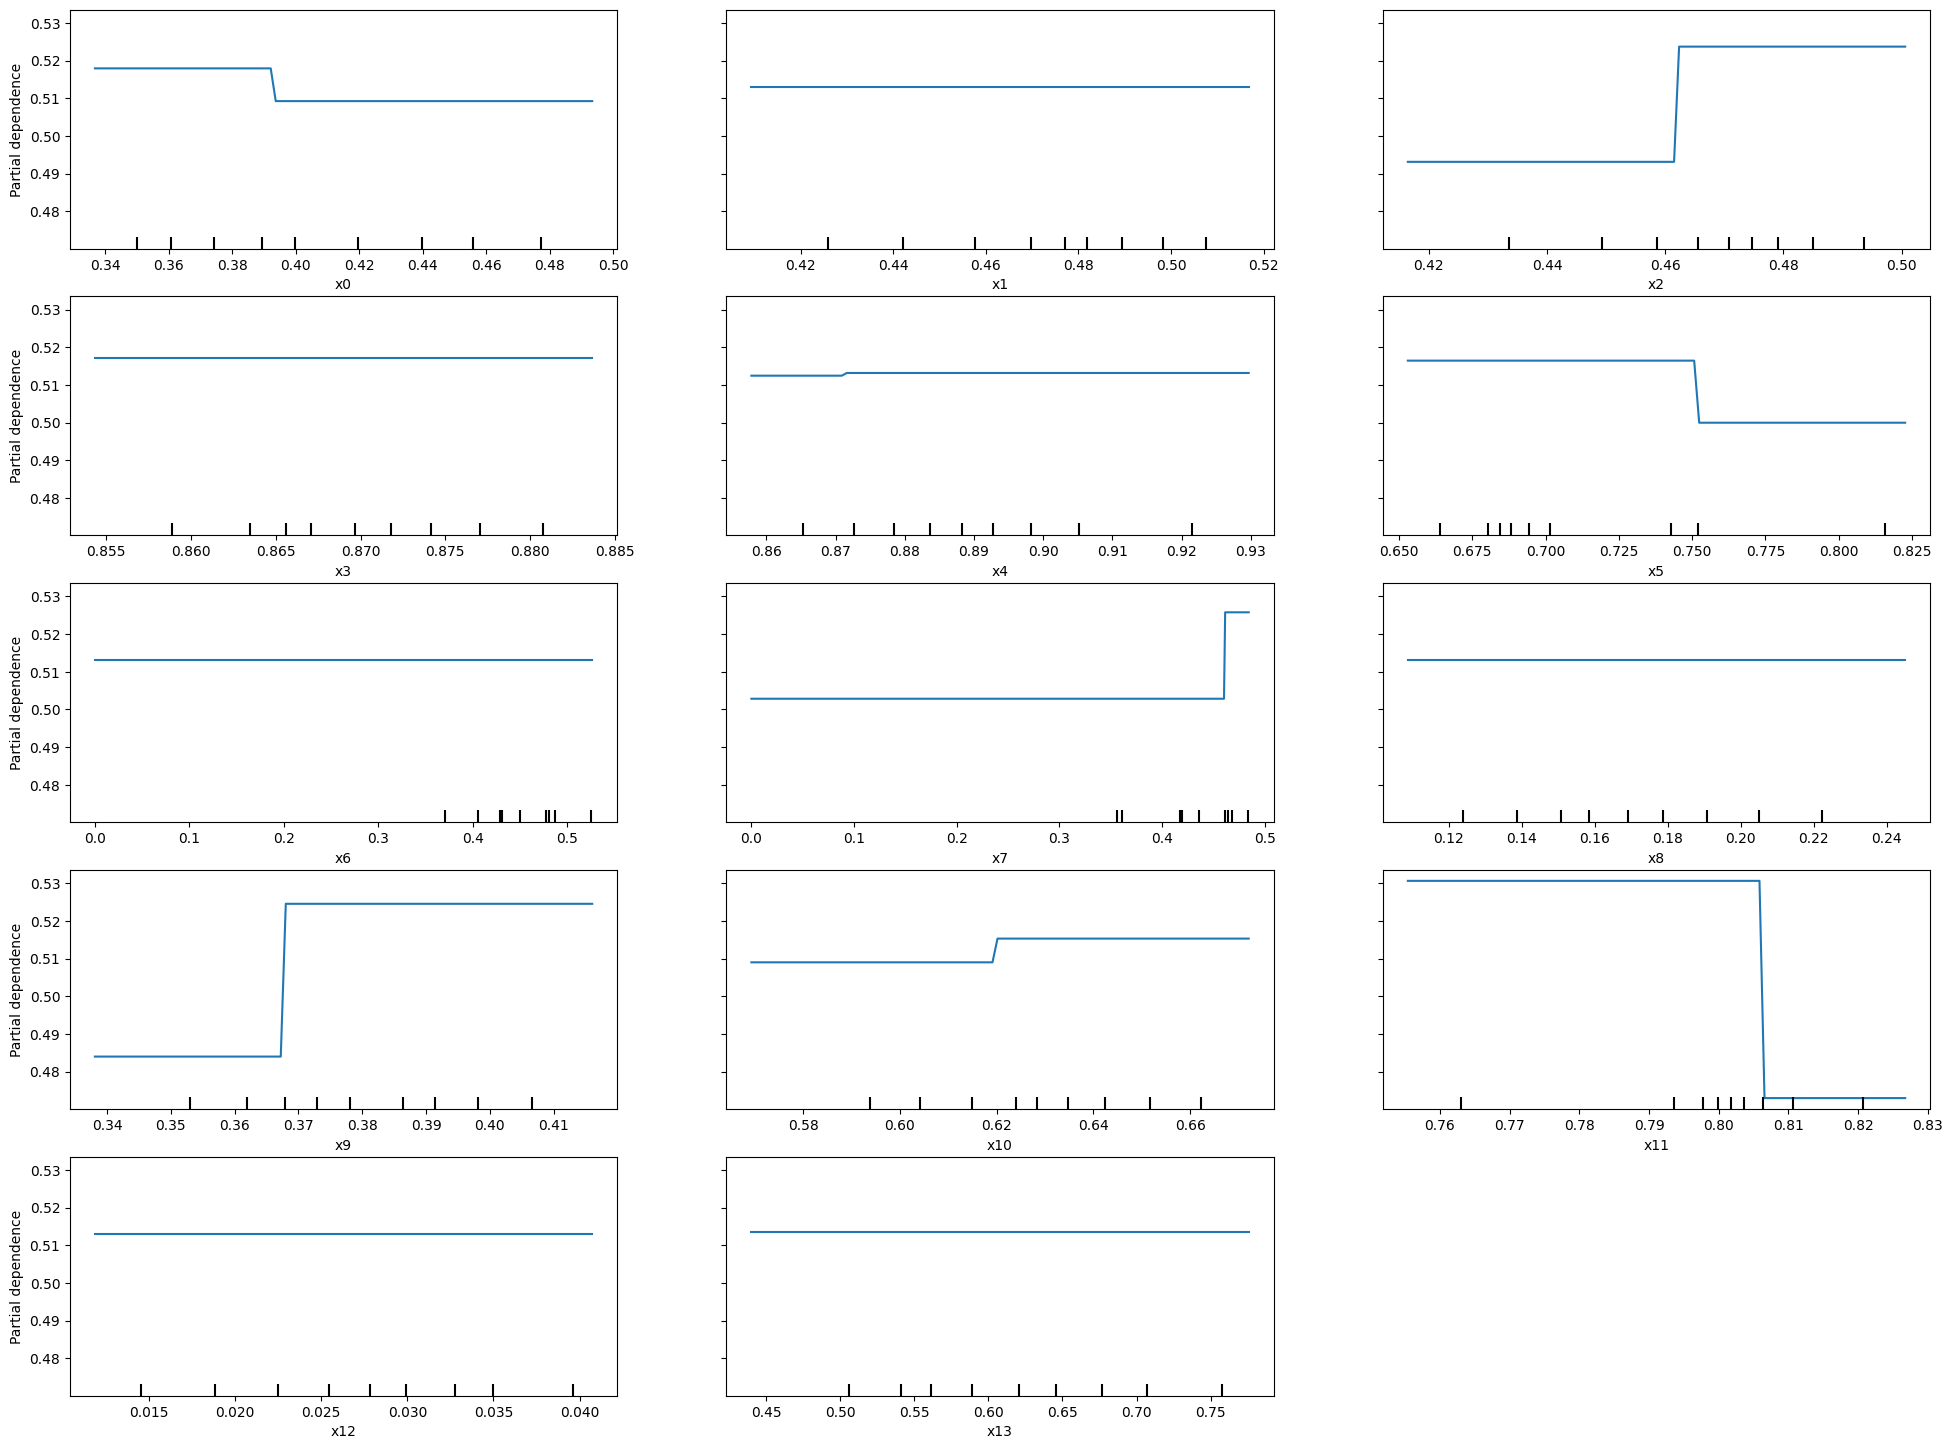

In [27]:
#Random Forest 
fig, ax = plt.subplots(figsize=(24, 18))
features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
PartialDependenceDisplay.from_estimator(forest, data_matrix_pdp,features,target=1,ax=ax)

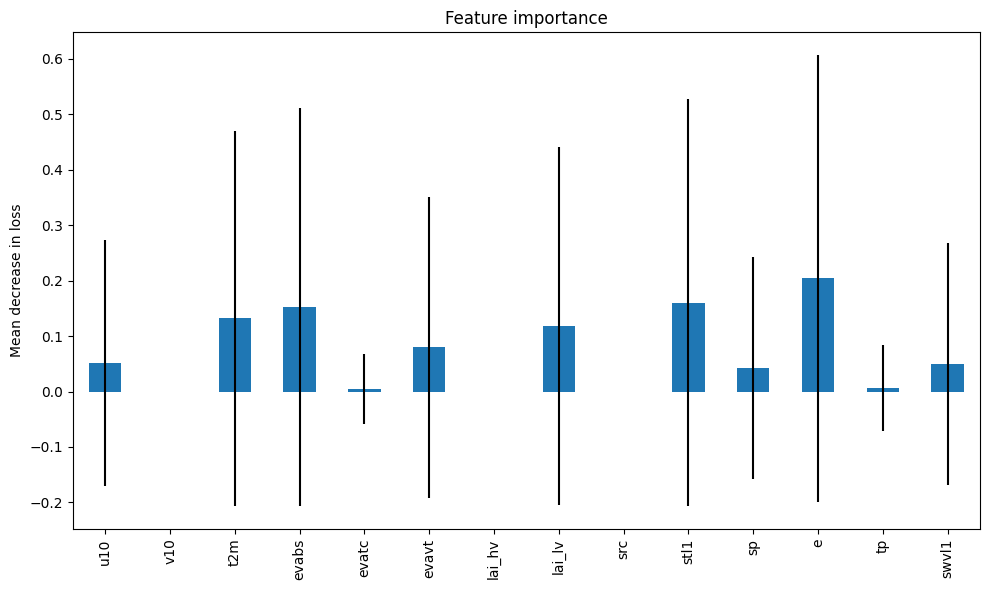

In [28]:


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=data_features)

fig, ax = plt.subplots(figsize=(10,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Mean decrease in loss")
fig.tight_layout()


## Gradient Boosting

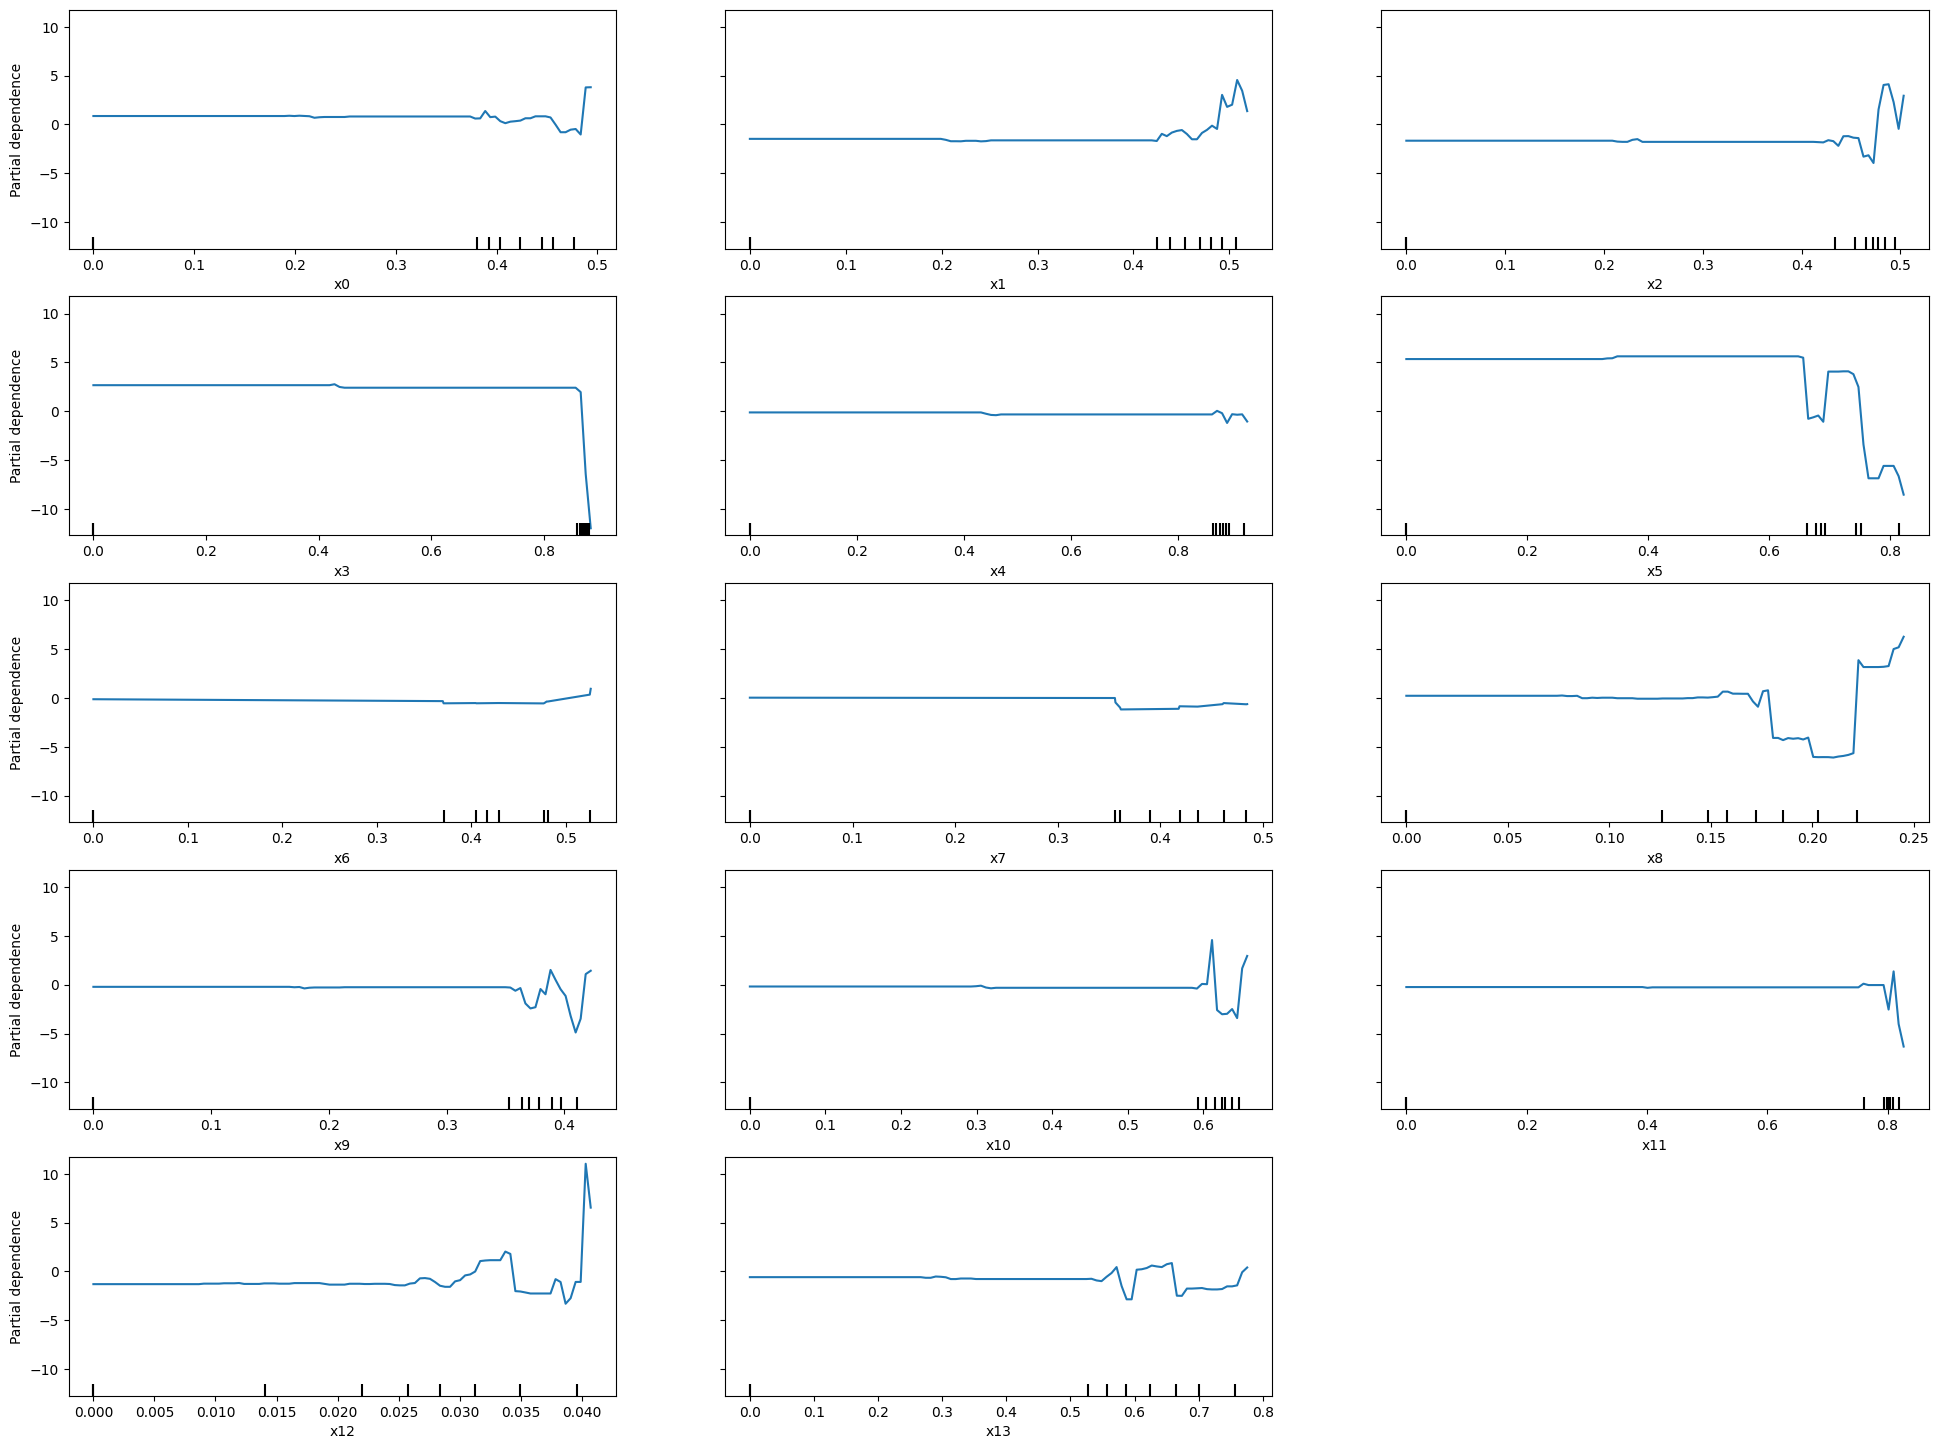

In [81]:

fig, ax = plt.subplots(figsize=(24, 18))

clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=13, random_state=np.random.randint(100)).fit(data_matrix_pdp, binary_labels_pdp)
features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
# features = [0,1,2,3,4,5,6,7]
PartialDependenceDisplay.from_estimator(clf, data_matrix_pdp,features,target=0,ax=ax)

In [82]:
f1=[]
for i in range(3):
    
    x_train, x_test, y_train, y_test = train_test_split(data_matrix_pdp10,binary_labels_pdp2, test_size=0.25, random_state=np.random.randint(100))

    clf.fit(x_train, y_train)

    #Prédiction sur les données de test avec le modèle entraîné 

    prediction= clf.predict(x_test)

    #Evaluation de la précision de classification du modèle
    f1.append(f1_score(y_test,prediction))
print('Score moyen de prédiction de classes pour ', nb_examples,' examples de résultats de production')

print(np.mean(f1),'+-',np.std(f1))


Score moyen de prédiction de classes pour  184  examples de résultats de production
0.4626068376068376 +- 0.06216810481186395


In [ ]:
import pyts
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

In [ ]:
clf = MultivariateClassifier(BOSSVS(n_bins=5,anova=True,word_size=9,drop_sum=True))
clf.fit(x_train, y_train)
MultivariateClassifier(...)
clf.predict(x_test)